# Sudodle simulations


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from sudodle_simulation import (
    cyclic_latin_square,
    uniform_random_latin_square,
    square_to_string,
    run_multiple_simulations_in_parallel,
)

from sudodle_plotting import plot_simulation_histogram


## Results starting from the classic cyclic latin square


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

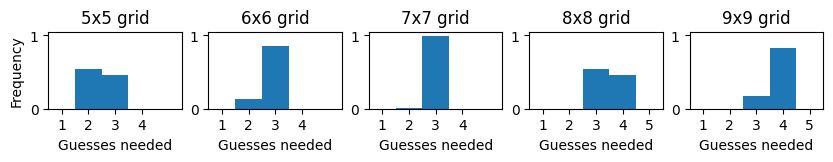

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
for i, ax in enumerate(axes):
    n = i + 5
    cyclic_square = cyclic_latin_square(n)
    tries_list = run_multiple_simulations_in_parallel(
        10_000 * [cyclic_square], n_processes=4
    )
    n_tries_list = [len(tries) + 1 for tries in tries_list if tries is not None]
    plot_simulation_histogram(n_tries_list, ax=ax, title=f"{n}x{n} grid")
    if ax != axes[0]:
        ax.set_ylabel("")
fig.savefig("outputs/simulation_5_to_9.jpeg", bbox_inches="tight")

## Results with 5 different (random) latin squares


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

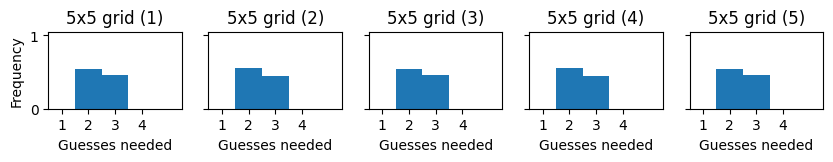

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
for i, ax in enumerate(axes):
    first_guess = uniform_random_latin_square(5)
    tries_list = run_multiple_simulations_in_parallel(10_000 * [first_guess])
    n_tries_list = [len(tries) + 1 for tries in tries_list if tries is not None]
    plot_simulation_histogram(n_tries_list, ax=ax, title=f"5x5 grid ({i + 1})")
    if ax != axes[0]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
fig.savefig("outputs/simulations_random_latin_squares.jpeg", bbox_inches="tight")


## Results with just random squares

(each square has 5 ones, 5 twos, etc.)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

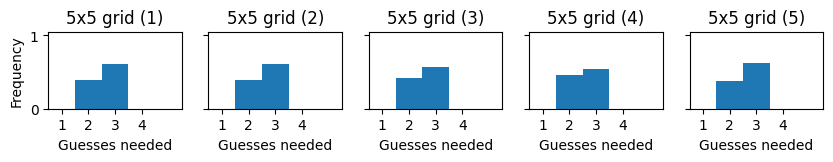

In [18]:
from sudodle_simulation import random_square

fig, axes = plt.subplots(1, 5, figsize=(10, 1))
first_guesses = [random_square(5) for _ in range(5)]
for i, (ax, first_guess) in enumerate(zip(axes, first_guesses)):
    tries_list = run_multiple_simulations_in_parallel(10_000 * [first_guess])
    n_tries_list = [len(tries) + 1 for tries in tries_list if tries is not None]
    plot_simulation_histogram(n_tries_list, ax=ax, title=f"5x5 grid ({i + 1})")
    if ax != axes[0]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
fig.savefig("outputs/simulations_random_squares.jpeg", bbox_inches="tight")

## The 1s-2s-3s... is maybe the worst first guess


| 1 1 1 1 1
| 2 2 2 2 2
| 3 3 3 3 3
| 4 4 4 4 4
| 5 5 5 5 5


Running simulations:   0%|          | 0/10000 [00:00<?, ?it/s]

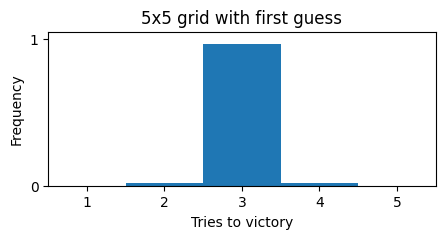

In [30]:
n = 5
first_guess = [n * [i + 1] for i in range(n)]
print(square_to_string(first_guess))
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
simulation_histogram(
    first_guess, ax, title="5x5 grid with first guess", sample_size=10_000
)

In [151]:
from sudodle_plotting import plot_puzzles_pdf_from_txt

for i in 4, 5, 6:
    plot_puzzles_pdf_from_txt(f"rust_puzzle_finder/outputs/s{i}.txt", i)

Successfully parsed 26 puzzles from rust_puzzle_finder/outputs/s4.txt
Successfully parsed 1560 puzzles from rust_puzzle_finder/outputs/s5.txt
Successfully parsed 57 puzzles from rust_puzzle_finder/outputs/s6.txt


## Process the mined puzzles


In [15]:
from sudodle_simulation import parse_puzzles_from_txt
from pathlib import Path

folder = Path("rust_puzzle_finder/outputs")


def compact_puzzles(file_name, N):
    puzzles = parse_puzzles_from_txt(folder / file_name, standardize_tiles=True)
    print(f"Found {len(puzzles)} puzzles in {file_name}")
    integers = [[N * i + j for (i, j) in tiles] for tiles in puzzles]
    character_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    characters_list = [
        ([str(N)] + [character_list[n] for n in tiles]) for tiles in integers
    ]
    return "\n".join(["".join(characters) for characters in sorted(characters_list)])


compacted_puzzles = "\n".join(
    compact_puzzles(file_name, N)
    for file_name, N in [
        ("s4.txt", 4),
        ("s5.txt", 5),
        ("s6.txt", 6),
        ("s7-p10-10M.txt", 7),
    ]
)
(Path("..") / "sudodle" / "public" / "compacted_puzzles.txt").write_text(
    compacted_puzzles
);


Found 26 puzzles in s4.txt
Found 1560 puzzles in s5.txt
Found 57 puzzles in s6.txt
Found 96 puzzles in s7-p10-10M.txt


In [6]:
from sudodle_simulation import (
    complete_latin_square_backtrack_all_solutions,
    cyclic_latin_square,
    parse_puzzles_from_txt,
)

cyclic_square = cyclic_latin_square(5)

known_values = {(0, 4): 5, (1, 3): 5, (2, 1): 4, (2, 3): 1}
known_wrong_values = {
    (i, j): [cyclic_square[i][j]]
    for i in range(5)
    for j in range(5)
    if (i, j) not in known_values
}
complete_latin_square_backtrack_all_solutions(
    size=5,
    known_values=known_values,
    known_wrong_values=known_wrong_values,
    max_solutions=10,
)

([[[2, 1, 4, 3, 5],
   [3, 2, 1, 5, 4],
   [5, 4, 2, 1, 3],
   [1, 3, 5, 4, 2],
   [4, 5, 3, 2, 1]]],
 [2, 6])

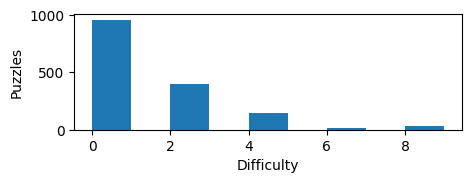

In [6]:
from sudodle_simulation import (
    parse_puzzles_from_txt,
    cyclic_latin_square,
    complete_latin_square_backtrack_all_solutions,
)
import matplotlib.pyplot as plt


def score_puzzle_difficulty(puzzle, grid_size):
    cyclic_square = cyclic_latin_square(grid_size)
    known_values = {(i, j): cyclic_square[i][j] for i, j in puzzle}
    known_wrong_values = {
        (i, j): [cyclic_square[i][j]]
        for i in range(grid_size)
        for j in range(grid_size)
    }
    solutions, branches = complete_latin_square_backtrack_all_solutions(
        size=grid_size,
        known_values=known_values,
        known_wrong_values=known_wrong_values,
        max_solutions=2,
    )
    assert len(solutions) == 1, f"Found {len(solutions)} solutions for {puzzle}"
    return sum(branches[:-1], 0)


def plot_difficulty_histogram(difficulties):
    fig, ax = plt.subplots(1, figsize=(5, 1.5))
    ax.hist(difficulties, bins=range(max(difficulties)))
    ax.set_xlabel("Difficulty")
    ax.set_ylabel("Puzzles")
    return fig, ax


puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s5.txt")
difficulties = [score_puzzle_difficulty(puzzle, 5) for puzzle in puzzles]

fig, ax = plot_difficulty_histogram(difficulties)
fig.savefig("outputs/5x5_difficulties.jpeg", bbox_inches="tight")


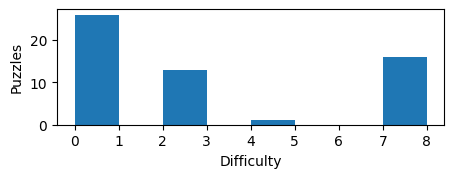

In [50]:
puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s6.txt")
difficulties = [score_puzzle_difficulty(puzzle, 6) for puzzle in puzzles]

fig, ax = plt.subplots(1, figsize=(5, 1.5))
ax.hist(difficulties, bins=range(max(difficulties)))
ax.set_xlabel("Difficulty")
ax.set_ylabel("Puzzles")
fig.savefig("outputs/5x5_difficulties.jpeg", bbox_inches="tight")


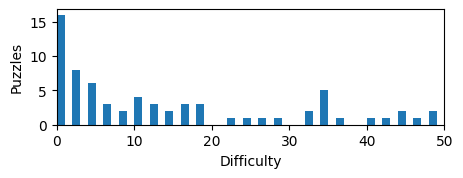

In [54]:
puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s7-p10-10M.txt")
difficulties = [score_puzzle_difficulty(puzzle, 7) for puzzle in puzzles]

fig, ax = plt.subplots(1, figsize=(5, 1.5))
ax.hist(difficulties, bins=range(max(difficulties)))
ax.set_xlabel("Difficulty")
ax.set_xlim(0, 50)
ax.set_ylabel("Puzzles")
fig.savefig("outputs/5x5_difficulties.jpeg", bbox_inches="tight")


In [83]:
from sudodle_simulation import parse_puzzles_from_txt
from sudodle_plotting import plot_puzzle
from pathlib import Path
import pandas

folder = Path("rust_puzzle_finder/outputs")


def compact_puzzle_string(puzzle, N):
    integers = [N * i + j for (i, j) in puzzle]
    character_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    return str(N) + "".join([character_list[n] for n in integers])


def compact_puzzles(file_name, N):
    puzzles = parse_puzzles_from_txt(folder / file_name, standardize_tiles=True)
    print(f"Found {len(puzzles)} puzzles in {file_name}")
    integers = [[N * i + j for (i, j) in tiles] for tiles in puzzles]
    character_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    characters_list = [
        ([str(N)] + [character_list[n] for n in tiles]) for tiles in integers
    ]
    return "\n".join(["".join(characters) for characters in sorted(characters_list)])


def difficulty_level(difficulty, difficulty_levels):
    for level in ["expert", "hard", "normal"]:
        if difficulty >= difficulty_levels[level]:
            return level
    raise ValueError(f"Difficulty {difficulty} is not in {difficulty_levels}")


records = []
for file_name, N, difficulty_levels in [
    ("s4.txt", 4, {"normal": 0, "hard": 1, "expert": 1}),
    ("s5.txt", 5, {"normal": 0, "hard": 2, "expert": 6}),
    ("s6.txt", 6, {"normal": 0, "hard": 2, "expert": 6}),
    ("s7-p10-10M.txt", 7, {"normal": 0, "hard": 2, "expert": 10}),
]:
    print("Processing", file_name)
    puzzles = parse_puzzles_from_txt(folder / file_name, standardize_tiles=True)
    difficulties = [score_puzzle_difficulty(puzzle, N) for puzzle in puzzles]
    for puzzle, difficulty in tqdm(zip(puzzles, difficulties)):
        level = difficulty_level(difficulty, difficulty_levels)
        compact_puzzle = compact_puzzle_string(puzzle, N)
        target = Path("outputs") / "svgs" / f"{compact_puzzle}.svg"
        target.parent.mkdir(parents=True, exist_ok=True)
        ax = plot_puzzle(N=N, well_placed_tiles=puzzle)
        ax.figure.savefig(target, bbox_inches="tight")
        plt.close(ax.figure)
        records.append(
            {
                "compacted_puzzle": compact_puzzle,
                "level": level,
                "image_path": str(target),
                "difficulty": difficulty,
            }
        )

pandas.DataFrame(records).to_csv("outputs/puzzles.csv", index=False)

Processing s4.txt


0it [00:00, ?it/s]

Processing s5.txt


0it [00:00, ?it/s]

Processing s6.txt


0it [00:00, ?it/s]

Processing s7-p10-10M.txt


0it [00:00, ?it/s]

In [82]:
df = pandas.read_csv("outputs/puzzles.csv")
df[["compacted_puzzle", "level"]].to_csv("../sudodle/public/puzzles.csv", index=False)

In [81]:
df

,compacted_puzzle,level,image_path
0,405,normal,outputs/svgs/405.svg
1,406,normal,outputs/svgs/406.svg
2,40B,normal,outputs/svgs/40B.svg
3,40F,normal,outputs/svgs/40F.svg
4,416,normal,outputs/svgs/416.svg
...,...,...,...
1734,736KSTVZdil,normal,outputs/svgs/736KSTVZdil.svg
1735,701BEFISXim,expert,outputs/svgs/701BEFISXim.svg
1736,71ADEFSVbck,expert,outputs/svgs/71ADEFSVbck.svg
1737,725JPSTbdgi,expert,outputs/svgs/725JPSTbdgi.svg


In [61]:
from sudodle_plotting import plot_puzzle

for puzzle, difficulty in zip(puzzles, difficulties):
    if difficulty > 45:
        plot_puzzle(N=7, well_placed_tiles=puzzle)
        break

900


(<Figure size 500x150 with 1 Axes>,
 <Axes: xlabel='Difficulty', ylabel='Puzzles'>)

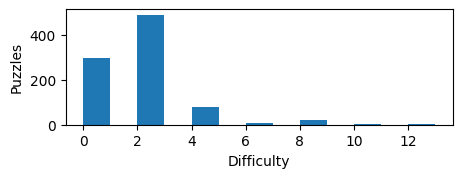

In [30]:
from sudodle_simulation import (
    parse_puzzles_from_txt,
    standardize_tile_tuple,
    complete_latin_square_backtrack_all_solutions,
)
from sudodle_plotting import plot_puzzles_to_pdf

s5_p4_puzzles = parse_puzzles_from_txt(
    "rust_puzzle_finder/outputs/s5.txt", standardize_tiles=True
)

s5_p5_puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s5-p5.txt")

s5_p6_puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s5-p6.txt")

s6_p6_puzzles = parse_puzzles_from_txt(
    "rust_puzzle_finder/outputs/s6.txt", standardize_tiles=True
)

s6_p7_puzzles = parse_puzzles_from_txt("rust_puzzle_finder/outputs/s6-p7.txt")

unique_to_p5 = set()
s5_p4_puzzles_set = set([tuple(puzzle) for puzzle in s5_p4_puzzles])
for puzzle in s5_p5_puzzles:
    for i in range(len(puzzle)):
        reduced_puzzle = tuple(puzzle[:i] + puzzle[i + 1 :])
        reduced_puzzle = standardize_tile_tuple(reduced_puzzle)
        if reduced_puzzle in s5_p4_puzzles_set:
            break
    else:
        unique_to_p5.add(standardize_tile_tuple(puzzle))
print(len(unique_to_p5))
difficulties = []
for puzzle in unique_to_p5:
    difficulty = score_puzzle_difficulty(puzzle, 5)
    difficulties.append(difficulty)

plot_difficulty_histogram(difficulties)
# plot_puzzles_to_pdf(unique_to_p5, 5, "outputs/s5-p5.pdf")


In [25]:
unique_to_p6 = set()
s5_p45_puzzles_set = set(
    [tuple(puzzle) for puzzle in s5_p4_puzzles + list(unique_to_p5)]
)
for puzzle in s5_p6_puzzles:
    for i in range(len(puzzle)):
        reduced_puzzle = tuple(puzzle[:i] + puzzle[i + 1 :])
        reduced_puzzle = standardize_tile_tuple(reduced_puzzle)
        if reduced_puzzle in s5_p45_puzzles_set:
            break
    else:
        unique_to_p6.add(standardize_tile_tuple(puzzle))
print(len(unique_to_p6))
difficulties = []
for puzzle in unique_to_p6:
    difficulty = score_puzzle_difficulty(puzzle, 5)
    difficulties.append(difficulty)

assert list(set(difficulties)) == [0]
# plot_puzzles_to_pdf(unique_to_p5, 5, "outputs/s5-p5.pdf")


4960


In [31]:
unique_to_s6p7 = set()
s6_p6_puzzles_set = set([tuple(puzzle) for puzzle in s6_p6_puzzles])
for puzzle in s6_p7_puzzles:
    for i in range(len(puzzle)):
        reduced_puzzle = tuple(puzzle[:i] + puzzle[i + 1 :])
        reduced_puzzle = standardize_tile_tuple(reduced_puzzle)
        if reduced_puzzle in s6_p6_puzzles_set:
            break
    else:
        unique_to_s6p7.add(standardize_tile_tuple(puzzle))
print(len(unique_to_s6p7))

93594


  0%|          | 0/93594 [00:00<?, ?it/s]

(<Figure size 500x150 with 1 Axes>,
 <Axes: xlabel='Difficulty', ylabel='Puzzles'>)

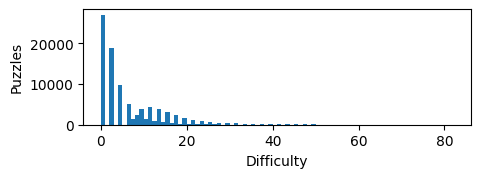

In [27]:
from tqdm.auto import tqdm

difficulties = []
for puzzle in tqdm(unique_to_s6p7):
    difficulty = score_puzzle_difficulty(puzzle, 6)
    difficulties.append(difficulty)

plot_difficulty_histogram(difficulties)
